In [1]:
from MADRLIV import plot_singlepref
from MADRLIV import unique_nontrival_winner

from MADRLIV import util_from_ranks
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
mems = ['Actions_now', False] #types of agent memory to record

agent_types = ['DQN'] #types of agent


#produce the preference profile

CV = (3,5)

opt,vr, metric_results,plurality_resultss = unique_nontrival_winner(CV[0],CV[1],'borda',restrict=True)

pp = [opt,vr]

alpha = 0.01
nt = 3000
epslen = 300

borda=  0.8       99.7 : 100%|████████████████████████████████| 6000/6000 [3:40:05<00:00,  2.08s/it]

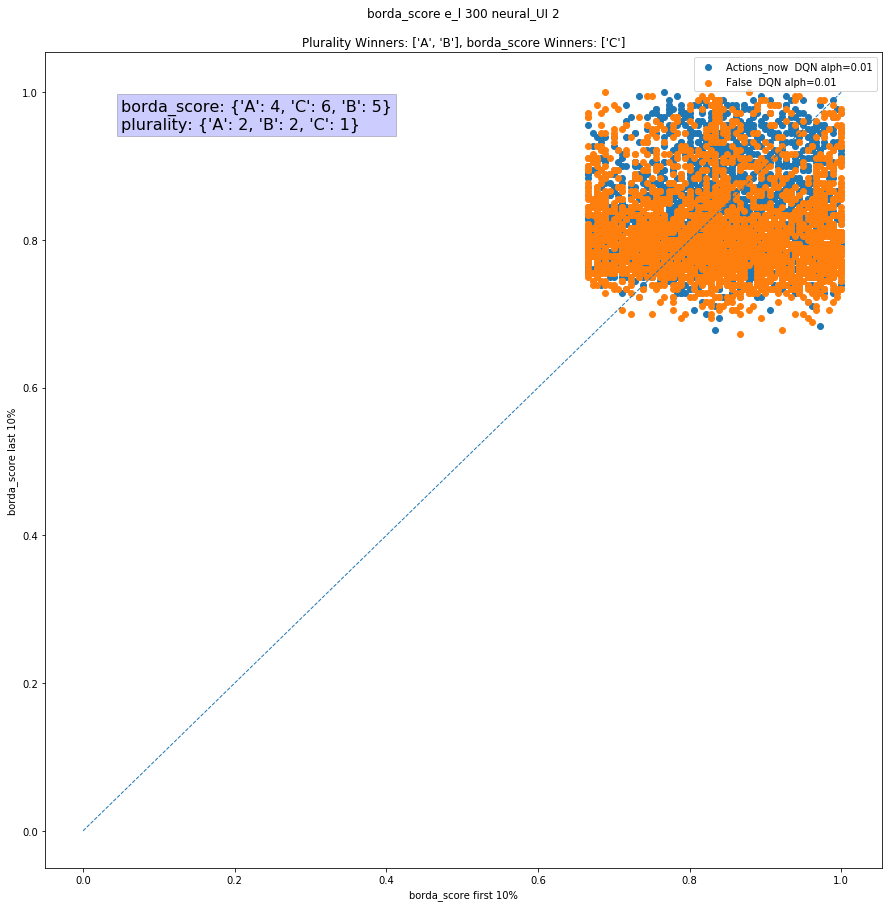

In [3]:
results_mix = plot_singlepref(fold=None,mems=mems,agent_types=agent_types,pref_profile=pp,agent_alpha=alpha,N_tests=nt,percent=10,metric='borda_score',eps_len=epslen,updateinterval=2)

In [4]:
#don't care about trained agents
for k in results_mix.keys():
    reslist = results_mix[k]
    scraped = [result[1] for result in reslist]
    results_mix[k] = scraped

In [5]:
#leave alone

In [6]:
vote_histories = {}
for k in results_mix.keys():
    vote_history = [(v.vote_history,v.vote_winners) for v in results_mix[k]]
    vote_histories[k] = vote_history

In [7]:
k = (False, 'DQN')
hist = vote_histories[k]

In [8]:

#for the 3 candidate situation:

#TRT - Truthful action - voting for candidate with utility 1.00
def TRT(utility):
    return float(utility==1.00)
#CMP - Compromise action - voting for utility 0.5 when utility 1.00 (most preferred option) is ranked last in poll (is losing consistently over a large enough past interval??)

#LB - Leader bias - voting for the leader of the poll = (consistent winner over a large enough past interval) that is either 0.5 or 0.25 utility

#DOM - Dominated actions - another action yields a higher expected utility "under very weak assumptions" = voting for the worst possible candidate (i.e. the last ranked option)??
#need to investigate - does 'no rational movitation' ONLY mean voting for last ranked option? Or could voting for 2nd option be DOMinated (probably no under 'very weak assumptions')

def DOM(utility):
    return float(utility==0.25)

#note that DOM and LB can go together, as can CMP and Leader bias

#so we have DLB (dominated leader bias) and CLB (compromise leader bias) for if you're voting for the poll leader (consistent leader) as a dominated or a compromise action

#NEED - history of vote winners to estimate LB. 'poll' has no direct equivalent

#In the second game a voter directly
#observes the current votes of her peers, but does not know
#how they will vote eventually at the final round (or when
#will the final round arrive).

#suggests the A ratios are based on past votes


"""
In the iterative voting game subjects could play up to
6 games in a sequence, each time with a different preference profile and with a different group of subjects (matched
at random). The games terminated when the voters converged, as described in Section 4.2, or if the number of
rounds reached a predetermined threshold unknown to the
participants (uniformly distributed between 5 and 10)
"""

#we also want to determine move types

"""
Following [18], we denote a compromise move as a change
in vote to a less-preferred candidate, and an opportunity
move as a change in vote to a more-preferred candidate. We
denote a stay move as no change in voting compared to the
previous round.
"""
def determine_move_type_from_utility_of_vote_assigned(utility,utility_last,move):
    #takes in utility score of the chosen option for this and last round - to see if agent moved or stayed and if they compromised or not
    if utility_last == None:
        #first move
        out= 0
    elif utility == utility_last:
        #stay move
        out= 0
    elif utility > utility_last:
        #opportunity move
        out= 1
    elif utility < utility_last:
        #compromise move
        out= -1
    elif (utility,utility_last) == (None,None):
        #fails
        raise InterruptedError
    
    if move == "opportunity":
        return(out==1)
    elif move == "stay":
        return(out==0)
    elif move == "compromise":
        return(out==-1)
    else:
        print(move)
        print("Invalid move/Atype")
        raise InterruptedError
    

def determine_A_type_from_utility_of_vote_assigned(utility,utility_last,winner_history, util_of_vote,A_type):
    if A_type == "TRT":
        return TRT(utility)
    elif A_type == "DOM":
        return DOM(utility)
    else:
        return determine_move_type_from_utility_of_vote_assigned(utility,utility_last,A_type)

def convert_to_numbers(winlist):
    return np.array([opt.index(i) for i in winlist])

In [9]:
def analyse_action_type(hist,A_type,ret=False):
    final_results = [np.zeros(epslen+1) for v in range(len(vr))]

    np.zeros(epslen+1)

    for pair in tqdm(hist,desc=A_type):
        run,winner_history = pair[0],convert_to_numbers(pair[1])
        
        agent_vote_utilities = [np.zeros(epslen+1) for v in range(len(vr))]
        
        for eps_number,step in enumerate(run):
            for agent_num,vote in enumerate(step):
                agents_prefs = vr[agent_num]
                util_of_vote = util_from_ranks(rank_list=agents_prefs,options=opt,use_exp=True)
                
                utility = util_of_vote[vote]
                
                #store for this run agent utility and get last utility
                v=agent_vote_utilities[agent_num]
                if eps_number == 0:
                    utility_last = None
                else:
                    utility_last = v[eps_number-1]
                v[eps_number] = utility
                agent_vote_utilities[agent_num] = v
                
                
                #record for the whole thing final a ratio type
                individual = final_results[agent_num]

                #takes in utility of this last vote, the history of which option numbers won and the preference profile over numbers (util of vote) to determine agent behaviour
                A = determine_A_type_from_utility_of_vote_assigned(utility,utility_last,winner_history, util_of_vote,A_type)

                individual[eps_number] += A
            #pbar.update(1)
        
    final_results = [a/nt for a in final_results]
    for idx,f in enumerate(final_results):
        #ratio of truthful to any other action
        final = int(len(f)*0.9)
        final_a_ratio = np.mean(f[final:])    
        print(vr[idx], round(final_a_ratio,4))
        label = str(vr[idx]) + " " + str(A_type)
        plt.plot(f,label=label)
        plt.title(A_type)
        plt.legend()
    if ret == True:
        return final_results


['A', 'C', 'B'] 0.0684
['A', 'C', 'B'] 0.0675
['B', 'C', 'A'] 0.069
['B', 'C', 'A'] 0.068
['C', 'B', 'A'] 0.0707



['A', 'C', 'B'] 0.8637
['A', 'C', 'B'] 0.8657
['B', 'C', 'A'] 0.8629
['B', 'C', 'A'] 0.8646
['C', 'B', 'A'] 0.8583



['A', 'C', 'B'] 0.0679
['A', 'C', 'B'] 0.0668
['B', 'C', 'A'] 0.0681
['B', 'C', 'A'] 0.0675
['C', 'B', 'A'] 0.071


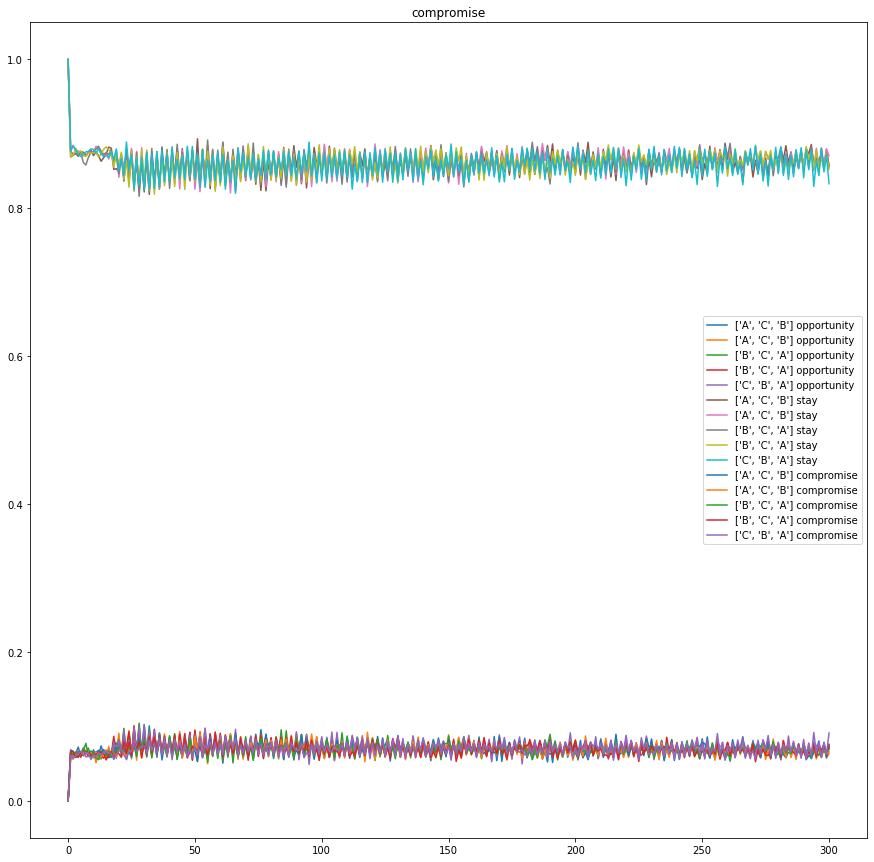

In [10]:
plt.figure(figsize=(15,15))
analyse_action_type(hist,'opportunity')
analyse_action_type(hist,'stay')
analyse_action_type(hist,'compromise')
plt.show()


['A', 'C', 'B'] 0.0511
['A', 'C', 'B'] 0.0546
['B', 'C', 'A'] 0.0473
['B', 'C', 'A'] 0.0483
['C', 'B', 'A'] 0.0575



['A', 'C', 'B'] 0.7996
['A', 'C', 'B'] 0.799
['B', 'C', 'A'] 0.8243
['B', 'C', 'A'] 0.8281
['C', 'B', 'A'] 0.71


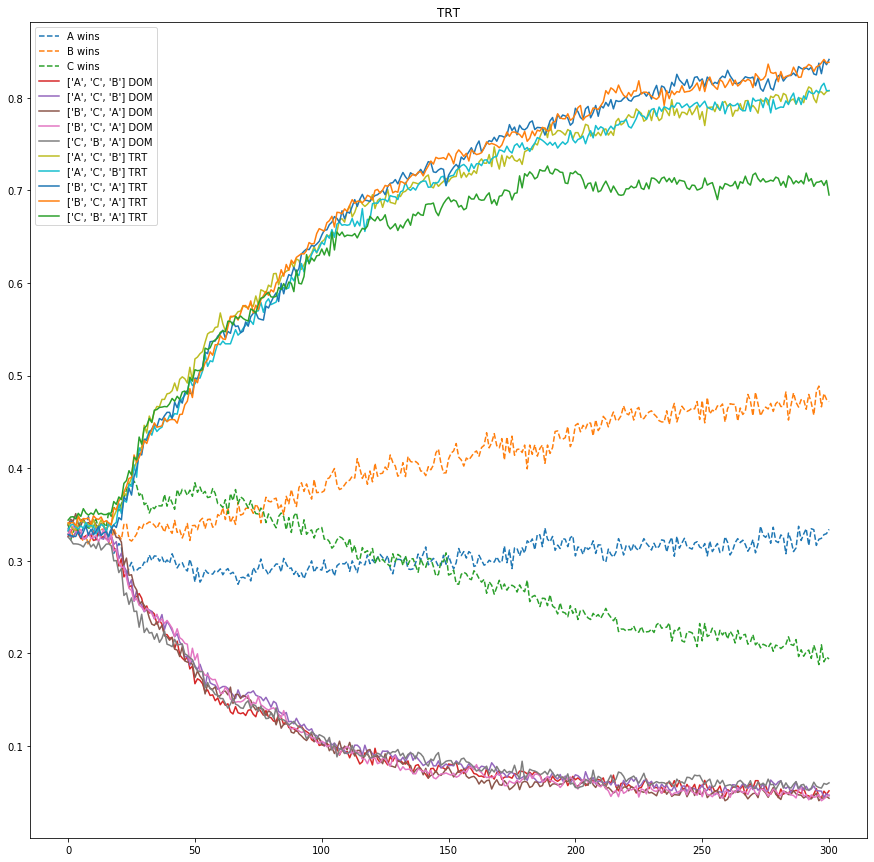

In [11]:
plt.figure(figsize=(15,15))

A,B,C = np.zeros(epslen+1),np.zeros(epslen+1),np.zeros(epslen+1)
for pair in tqdm(hist):
    winner_history = convert_to_numbers(pair[1])
    A += (winner_history==0)
    B += (winner_history==1)
    C += (winner_history==2)
A,B,C = A/len(hist),B/len(hist),C/len(hist)

plt.plot(A,'--',label = 'A wins')
plt.plot(B,'--',label = 'B wins')
plt.plot(C,'--',label = 'C wins')

analyse_action_type(hist,'DOM')
analyse_action_type(hist,'TRT')

plt.show()